In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [13, 11]

In [82]:
# Parse config.txt file
# the first line is the number of entries
# then each line is the fitting result with params a,b,c,d,mean,std
# then there is a line for the number of data points in the fit
# each line is a data point x,y
def parse_config(filename):
    with open(filename) as f:
        num_entries = int(f.readline())
        entries = []
        for i in range(num_entries):
            line = f.readline()
            entry = line.split(',')
            # add tuple (params, mean, std)
            entries.append((list(map(float,entry[0:-2])), float(entry[-2]), float(entry[-1])))
        data = []
        for i in range(num_entries):
            num_data_points = int(f.readline())
            data_points = []
            for i in range(num_data_points):
                line = f.readline()
                x,y = line.split(',')
                data_points.append((float(x),float(y)))
            data_points.sort(key=lambda x: x[1])
            data.append(data_points)
        return entries, data

config = parse_config("config.txt")

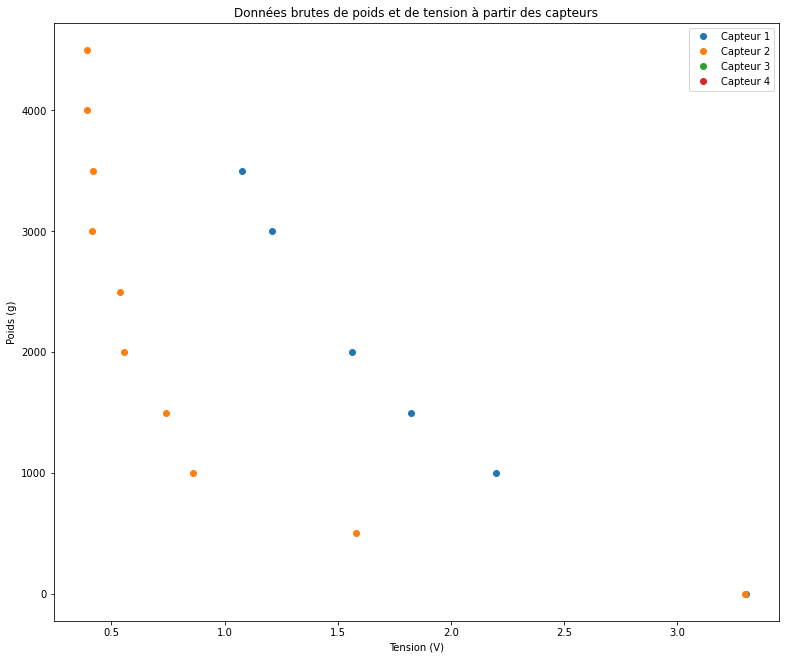

In [83]:
# Plot the data points
def plot_data(data):
    for i in range(len(data)):
        x = [d[0] for d in data[i]]
        y = [d[1] for d in data[i]]
        plt.plot(x,y,'o', label='Capteur {}'.format(i+1))
        plt.xlabel('Tension (V)')
        plt.ylabel('Poids (g)')
    plt.legend()
    plt.title("Données brutes de poids et de tension à partir des capteurs")
    plt.show()

plot_data(config[1])


[([5.46323, 0.7569129, -3.745374], 1833.5, 1178.252), ([0.5475663, 1.719218, -1.551831], 2250.1, 1435.984), ([0.0, 0.0, 0.0], 0.0, 1.0), ([0.0, 0.0, 0.0], 0.0, 1.0)]


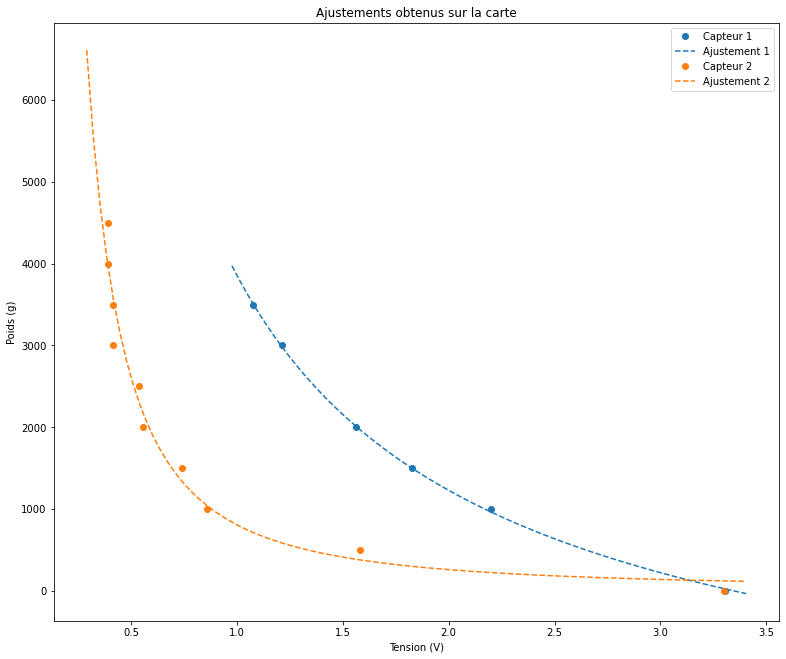

In [84]:
def func(x, a, b,c):
    return a/x**b + c

# Plot the fit
def plot_fit(data, entries):
    for i in range(len(data)):
        x = [d[0] for d in data[i]]
        y = [d[1] for d in data[i]]
        if x == []:
            continue
        plt.plot(x,y,'o', label='Capteur {}'.format(i+1), color='C{}'.format(i))
        plt.xlabel('Tension (V)')
        plt.ylabel('Poids (g)')
        x = np.linspace(min(x) - 0.1, max(x) + 0.1, 100)
        plt.plot(x, func(np.array(x), *entries[i][0])  * entries[i][2] + entries[i][1],'--', label='Ajustement {}'.format(i+1), color='C{}'.format(i))
    plt.legend()
    plt.title("Ajustements obtenus sur la carte")
    plt.show()
print(config[0])
plot_fit(config[1], config[0])

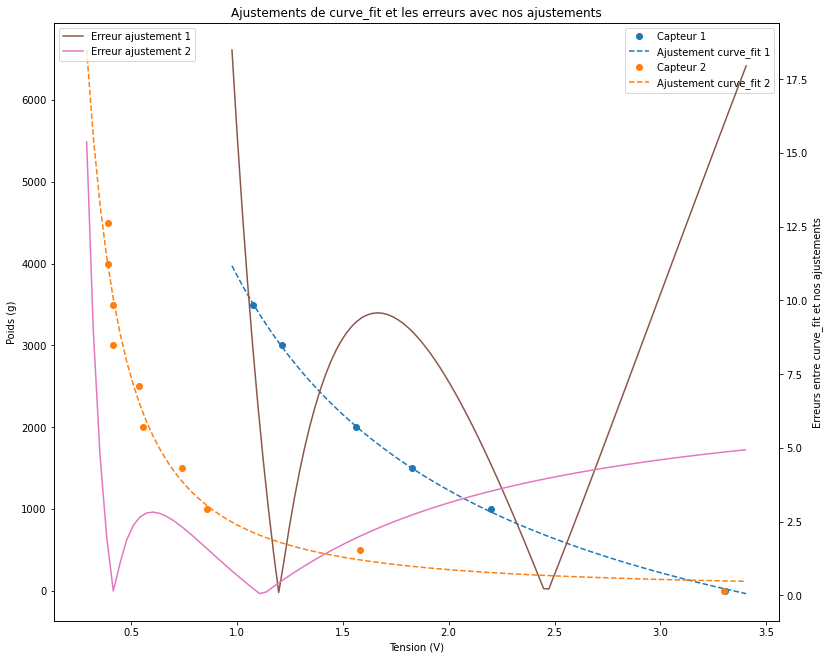

In [85]:
# Plot fit using scipy curve_fit and plot the error bewteen the two fits using antoher axis
def plot_fit_scipy(data, entries):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for i in range(len(data)):
        x = [d[0] for d in data[i]]
        y = [d[1] for d in data[i]]
        if x == []:
            continue
        ax1.plot(x,y,'o', label='Capteur {}'.format(i+1), color='C{}'.format(i))
        ax1.set_xlabel('Tension (V)')
        ax1.set_ylabel('Poids (g)')
        popt, pcov = curve_fit(func, x, y)
        x = np.linspace(min(x) - 0.1, max(x) + 0.1, 100)
        ax1.plot(x, func(np.array(x), *entries[i][0])  * entries[i][2] + entries[i][1],'--', label='Ajustement curve_fit {}'.format(i+1), color='C{}'.format(i))
        # plot the error between the two fits
        error = func(np.array(x), *entries[i][0])  * entries[i][2] + entries[i][1] - func(np.array(x), *popt)
        ax2.plot(x, np.abs(error), label='Erreur ajustement {}'.format(i+1), color='C{}'.format(i + len(data)  + 1))
    ax2.set_ylabel('Erreurs entre curve_fit et nos ajustements')
    ax1.legend()
    ax2.legend(loc = "upper left")
    plt.title("Ajustements de curve_fit et les erreurs avec nos ajustements")
    plt.show()

plot_fit_scipy(config[1], config[0])